<a href="https://colab.research.google.com/github/jrastogi1349342/jrastogi1349342.github.io/blob/master/biosignals_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Bio-Signals to Predict Smoker Status
#### By Jai Rastogi

<br>

I chose the following dataset: https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

I decided on using this dataset because it provides over 55,000 rows of biological data, including bio-signals like the levels of individual hormones and proteins, about both smokers and non-smokers. I am interested in determining if there are any strong trends or clusters between any combination of these bio-signals and smoking.

# Data Preprocessing

This code installs and imports all the necessary packages.

In [63]:
!pip install factor_analyzer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from prettytable import PrettyTable

pd.options.display.max_columns = None
plt.style.use("ggplot")

This code loads in the train and test datasets, which were already split. The test dataset does not contain the 'smoking' attribute. However, this means that there is the possibility that there exist duplicate rows within and across the datasets. This following code block removes rows that are duplicated in the same dataset.

In [64]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

train_df.info()
print("\n\n")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33467 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  33467 non-null  int64  
 1   height(cm)           33467 non-null  int64  
 2   weight(kg)           33467 non-null  int64  
 3   waist(cm)            33467 non-null  float64
 4   eyesight(left)       33467 non-null  float64
 5   eyesight(right)      33467 non-null  float64
 6   hearing(left)        33467 non-null  int64  
 7   hearing(right)       33467 non-null  int64  
 8   systolic             33467 non-null  int64  
 9   relaxation           33467 non-null  int64  
 10  fasting blood sugar  33467 non-null  int64  
 11  Cholesterol          33467 non-null  int64  
 12  triglyceride         33467 non-null  int64  
 13  HDL                  33467 non-null  int64  
 14  LDL                  33467 non-null  int64  
 15  hemoglobin           33467 non-null 

There are no null values in either dataset, so no imputation is necessary.

The following code block deals with rows that are duplicated between the train and test datasets. Specifically, the copy is removed from the train dataset. This is because the train dataset is approximately twice as large as the test dataset, and removing some rows from the train dataset still yields a workable ratio.

In [65]:
# Drop rows that are duplicated between the given train and test datasets

df_merge = pd.merge(train_df, test_df, how='inner')
merged = pd.concat([train_df, df_merge])

merged['Duplicated'] = merged.duplicated(subset=['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'], keep=False)

print("Number of duplicated rows between the train and test datasets: ", (merged['Duplicated'].sum() / 2), "\n\n")

train_df = merged[~merged['Duplicated']]
del train_df['Duplicated']

features_lst = list(set(train_df.columns) - set(['smoking']))

train_df.info()
print("\n\n")
test_df.info()

Number of duplicated rows between the train and test datasets:  4625.0 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28842 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  28842 non-null  int64  
 1   height(cm)           28842 non-null  int64  
 2   weight(kg)           28842 non-null  int64  
 3   waist(cm)            28842 non-null  float64
 4   eyesight(left)       28842 non-null  float64
 5   eyesight(right)      28842 non-null  float64
 6   hearing(left)        28842 non-null  int64  
 7   hearing(right)       28842 non-null  int64  
 8   systolic             28842 non-null  int64  
 9   relaxation           28842 non-null  int64  
 10  fasting blood sugar  28842 non-null  int64  
 11  Cholesterol          28842 non-null  int64  
 12  triglyceride         28842 non-null  int64  
 13  HDL                  28842 non-null  int64  
 14  LDL         

# Statistical Method #1
It must be determined whether the given train and test datasets have similar trends to each other. If the test dataset is not representative of the train dataset, the machine learning model would be evaluated on data with different trends than what it was trained with, resulting in the model having poorly trained hyperparameters, low precision and accuracy, and poor robustness.

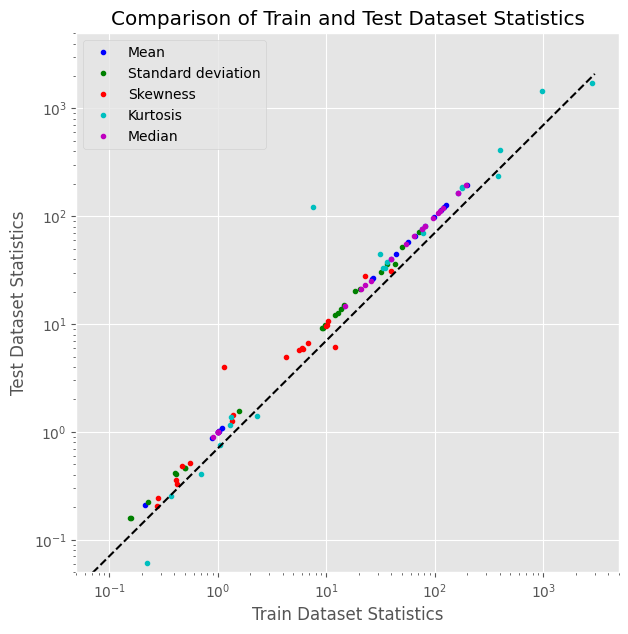

Pearson correlation coefficient:  0.9286905845905339


In [66]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='k')

plt.figure(figsize=(7, 7))

train_pts_lst = pd.concat([train_df[features_lst].mean(), train_df[features_lst].std(),
                          train_df[features_lst].skew(), train_df[features_lst].kurtosis(),
                          train_df[features_lst].median()]).tolist()

test_pts_lst = pd.concat([test_df[features_lst].mean(), test_df[features_lst].std(),
                          test_df[features_lst].skew(), test_df[features_lst].kurtosis(),
                          test_df[features_lst].median()]).tolist()

slope, intercept, r_value, p_value, std_err = stats.linregress(train_pts_lst, test_pts_lst)

plt.plot(train_df[features_lst].mean(), test_df[features_lst].mean(), 'b.', label='Mean')
plt.plot(train_df[features_lst].std(), test_df[features_lst].std(), 'g.', label='Standard deviation')
plt.plot(train_df[features_lst].skew(), test_df[features_lst].skew(), 'r.', label='Skewness')
plt.plot(train_df[features_lst].kurtosis(), test_df[features_lst].kurtosis(), 'c.', label='Kurtosis')
plt.plot(train_df[features_lst].median(), test_df[features_lst].median(), 'm.', label='Median')

abline(slope, intercept)

plt.title('Comparison of Train and Test Dataset Statistics')
plt.xlabel('Train Dataset Statistics')
plt.ylabel('Test Dataset Statistics')

plt.xlim(5e-2, 5e3)
plt.ylim(5e-2, 5e3)
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.show()

print('Pearson correlation coefficient: ', r_value)

Since the Pearson Correlation Coefficient of this linear regression is 0.929, there is a strong positive trend between the test and train data statistics. Therefore, the test dataset can be used to test the accuracy and efficacy of the machine learning model.

# Statistical Method #2
In order to see if a machine learning model can find trends in the biomarkers between smokers and non-smokers, there needs to exist some set of differences between the two groups for at least one characteristic. Here, the first step is feature engineering, adding four more characteristics, so that there are potentially more differences for a ML model to determine. These characteristics are easily calculated by doing basic mathematical operations on the original datasets, and have a broader meaning in the field of biology.

* BMI refers to the body mass index, which measures body fat based on height and weight.
* The Blood Pressure Difference refers to the difference between the Systolic and Relaxation Blood Pressures, which is the Pulse Pressure.
* The HDL-LDL ratio refers to HDL (high-density lipoprotein) cholesterol divided by LDL (low-density lipoprotein) cholesterol. This can be significant because research experiments have found [links](https://www.healthline.com/health/smoking-and-cholesterol#heart-attack-risk:~:text=lung%20cancer-,Beyond,-the%20impact%20on) between smoking, and lower HDL levels and higher LDL levels.
* The Liver Enzyme Ratio refers to the ratio between AST (Aspartate aminotransferase) and ALT (alanine aminotransferase). This ratio helps medical professionals diagnose liver injuries, and smoking is known to impact the liver.

In [67]:
def bmi(x):
  return x['weight(kg)'] / ((x['height(cm)'] / 100) ** 2)

def bp_diff(x):
  return x['systolic'] - x['relaxation']

def hdl_ldl_ratio(x):
  return x['HDL'] / x['LDL']

def liver_enzyme_ratio(x):
  return x['AST'] / x['ALT']

train_df['BMI'] = train_df.apply(lambda x : bmi(x), axis=1)
test_df['BMI'] = test_df.apply(lambda x : bmi(x), axis=1)

train_df['BP Diff'] = train_df.apply(lambda x : bp_diff(x), axis=1)
test_df['BP Diff'] = test_df.apply(lambda x : bp_diff(x), axis=1)

train_df['HDL-LDL Ratio'] = train_df.apply(lambda x : hdl_ldl_ratio(x), axis=1)
test_df['HDL-LDL Ratio'] = test_df.apply(lambda x : hdl_ldl_ratio(x), axis=1)

train_df['Liver Enzyme Ratio'] = train_df.apply(lambda x : liver_enzyme_ratio(x), axis=1)
test_df['Liver Enzyme Ratio'] = test_df.apply(lambda x : liver_enzyme_ratio(x), axis=1)

train_df.head()
test_df.head()

<ipython-input-67-4c84ab14bb6f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['BMI'] = train_df.apply(lambda x : bmi(x), axis=1)
<ipython-input-67-4c84ab14bb6f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['BP Diff'] = train_df.apply(lambda x : bp_diff(x), axis=1)
<ipython-input-67-4c84ab14bb6f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,BP Diff,HDL-LDL Ratio,Liver Enzyme Ratio
0,40,170,65,75.1,1.0,0.9,1,1,120,70,102,225,260,41,132,15.7,1,0.8,24,26,32,0,22.491349,50.0,0.310606,0.923077
1,45,170,75,89.0,0.7,1.2,1,1,100,67,96,258,345,49,140,15.7,1,1.1,26,28,138,0,25.951557,33.0,0.350000,0.928571
2,30,180,90,94.0,1.0,0.8,1,1,115,72,88,177,103,53,103,13.5,1,1.0,19,29,30,0,27.777778,43.0,0.514563,0.655172
3,60,170,50,73.0,0.5,0.7,1,1,118,78,86,187,70,65,108,14.1,1,1.3,31,28,33,0,17.301038,40.0,0.601852,1.107143
4,30,170,65,78.0,1.5,1.0,1,1,110,70,87,190,210,45,103,14.7,1,0.8,21,21,19,0,22.491349,40.0,0.436893,1.000000


Before performing the statistical tests, a violin plot of each characteristic, grouped by smoking status, is displayed to compare the distributions.

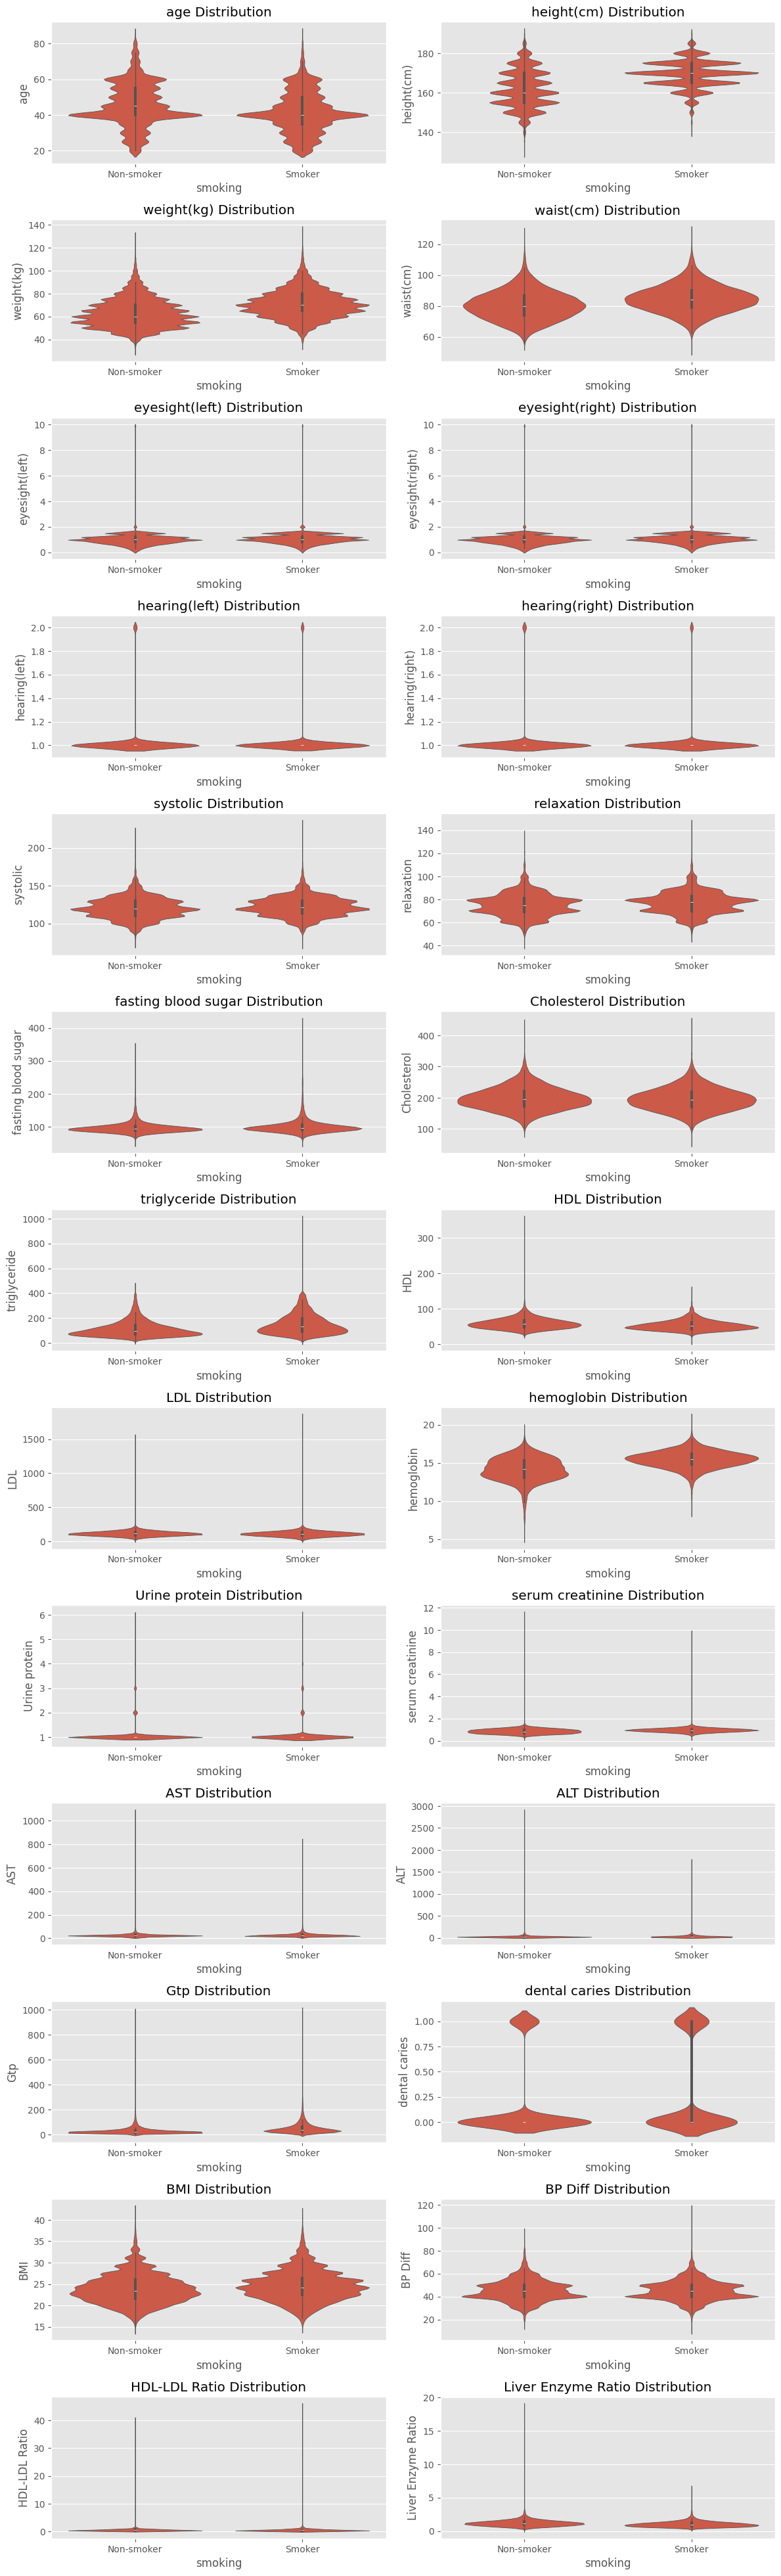

In [68]:
cols = train_df.columns.tolist()
cols.remove('smoking')

num_rows = len(cols)
num_cols = 2

total_plots = num_rows * num_cols
plt.figure(figsize=(12, num_rows * 3))

for idx, col in enumerate(cols):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.violinplot(x=train_df['smoking'], y=col, data=train_df)
    plt.title(f"{col} Distribution")
    plt.xticks(ticks=[0, 1], labels=['Non-smoker', 'Smoker'])

plt.tight_layout()
plt.show()

There are some characteristics where there is visibly a difference in the distribution between smokers and non-smokers from the graphs, namely:
* Height
* Weight
* Waist size
* Triglycerides
* Hemoglobin

More formally, a two sample T Test can be conducted for each attribute to determine if the difference in means is significant. That is, for each characteristic:

* *H0*: the mean of the characteristic is the same between the group of non-smokers and smokers.

* *HA*: the mean of the characteristic is different between the group of non-smokers and smokers.

The following code conducts the hypothesis test for each characteristic and prints the resulting p values.

In [69]:
t = PrettyTable(['Column', 'P Value', 'Statistically Significant'])

for idx, col in enumerate(cols):
  non_smokers = train_df[train_df['smoking'] == 0][col].tolist()
  smokers = train_df[train_df['smoking'] == 1][col].tolist()

  no_var = np.var(non_smokers)
  yes_var = np.var(smokers)

  if max(no_var, yes_var) / min(no_var, yes_var) <= 4:
    stat, p_val = stats.ttest_ind(a=non_smokers, b=smokers, equal_var=True)
    t.add_row([col, p_val, (p_val < 0.05)])
  else:
    stat, p_val = stats.ttest_ind(a=non_smokers, b=smokers, equal_var=False)
    t.add_row([col, p_val, (p_val < 0.05)])
print(t)

+---------------------+-------------------------+---------------------------+
|        Column       |         P Value         | Statistically Significant |
+---------------------+-------------------------+---------------------------+
|         age         | 2.9748195937127138e-176 |            True           |
|      height(cm)     |           0.0           |            True           |
|      weight(kg)     |           0.0           |            True           |
|      waist(cm)      |           0.0           |            True           |
|    eyesight(left)   |  3.3145093896351197e-22 |            True           |
|   eyesight(right)   |  1.030825638404225e-27  |            True           |
|    hearing(left)    |  0.00021542870058488233 |            True           |
|    hearing(right)   |   0.004243107412020721  |            True           |
|       systolic      |  5.3389109236324125e-33 |            True           |
|      relaxation     |  3.587665238757433e-67  |            Tru

The value of $\alpha$ used in these hypothesis tests is $0.05$. The p value for the two sample T Test is less than $\alpha$ for every characteristic apart from 'BP Diff', or the difference between the Systolic and Relaxation Blood Pressures. Therefore, there is a statistically significant difference between the means of each characteristic, apart from Blood Pressure Difference, when compared between non-smokers and smokers. This means that there exist many markers that the ML model can utilize to predict if a person is a smoker or non-smoker, based on solely biomarker data.

# Statistical Method #3
Another important thing to note is how each characteristic correlates to each other, and if characteristics can be removed without the loss of information. So, correlation heatmaps are calculated for both the train and test datasets, some non-obvious correlations are examined, and a few tests are run.

<Axes: >

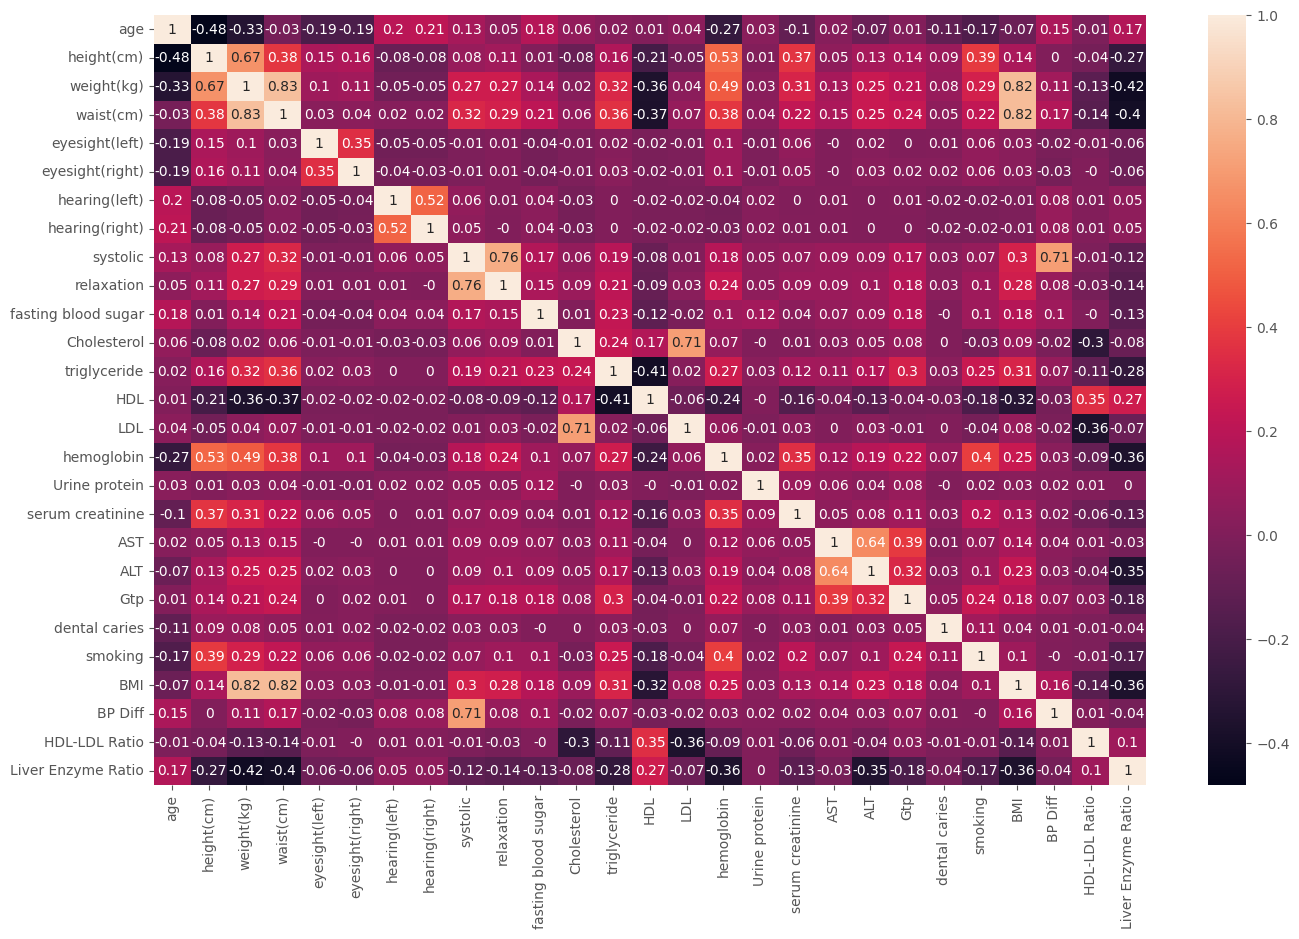

In [70]:
fig, ax = plt.subplots(figsize=(16,10))
train_corr = train_df.corr().round(2)
sns.heatmap(train_corr, annot=True, ax=ax)

There are some moderately strong correlations between two characteristics. Some of these are expected because the data points measure similar attributes of the person. Examples include the following:
* Left and right eyesight
* Left and right hearing
* Cholesterol and LDL (LDL is a type of cholesterol)
* AST and ALT (both are liver enzymes)

There are also some correlations that aren't immediately obvious, as such as those graphed below:


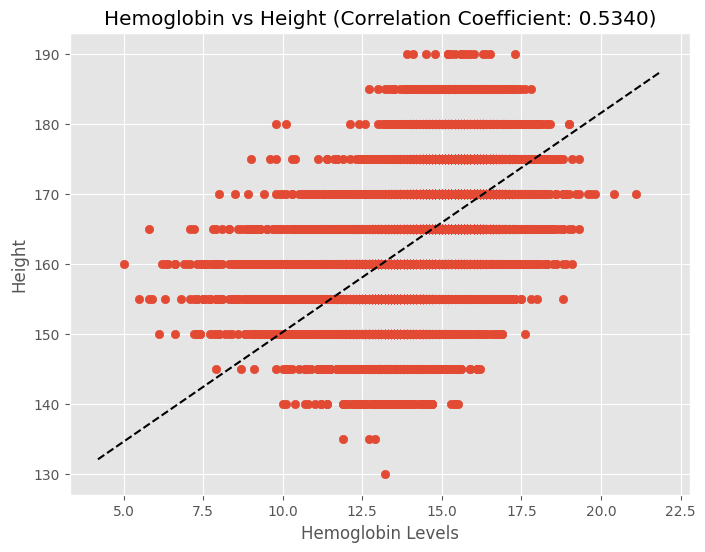

In [71]:
hemo_height_corr_coeff = train_df['hemoglobin'].corr(train_df['height(cm)'])

plt.figure(figsize=(8, 6))
plt.scatter(train_df['hemoglobin'], train_df['height(cm)'])
plt.xlabel('Hemoglobin Levels')
plt.ylabel('Height')
plt.title(f'Hemoglobin vs Height (Correlation Coefficient: {hemo_height_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_df['hemoglobin'].tolist(), train_df['height(cm)'].tolist())
abline(slope, intercept)

plt.show()

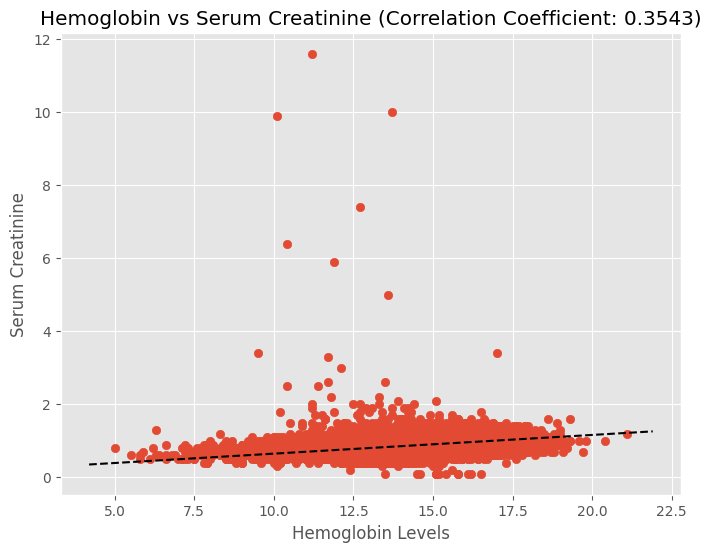

In [72]:
hemo_serum_corr_coeff = train_df['hemoglobin'].corr(train_df['serum creatinine'])

plt.figure(figsize=(8, 6))
plt.scatter(train_df['hemoglobin'], train_df['serum creatinine'])
plt.xlabel('Hemoglobin Levels')
plt.ylabel('Serum Creatinine')
plt.title(f'Hemoglobin vs Serum Creatinine (Correlation Coefficient: {hemo_serum_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_df['hemoglobin'].tolist(), train_df['serum creatinine'].tolist())
abline(slope, intercept)

plt.show()

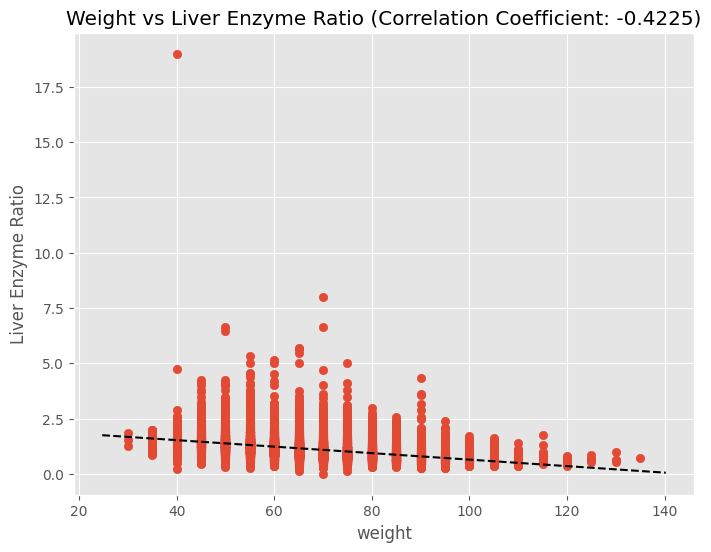

In [73]:
hemo_serum_corr_coeff = train_df['weight(kg)'].corr(train_df['Liver Enzyme Ratio'])

plt.figure(figsize=(8, 6))
plt.scatter(train_df['weight(kg)'], train_df['Liver Enzyme Ratio'])
plt.xlabel('weight')
plt.ylabel('Liver Enzyme Ratio')
plt.title(f'Weight vs Liver Enzyme Ratio (Correlation Coefficient: {hemo_serum_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_df['weight(kg)'].tolist(), train_df['Liver Enzyme Ratio'].tolist())
abline(slope, intercept)

plt.show()

Clearly, there are a few moderately strong correlations between characteristics.

The correlations on the test dataset can also be checked to further ensure that it is representative of the data in the train dataset.

<Axes: >

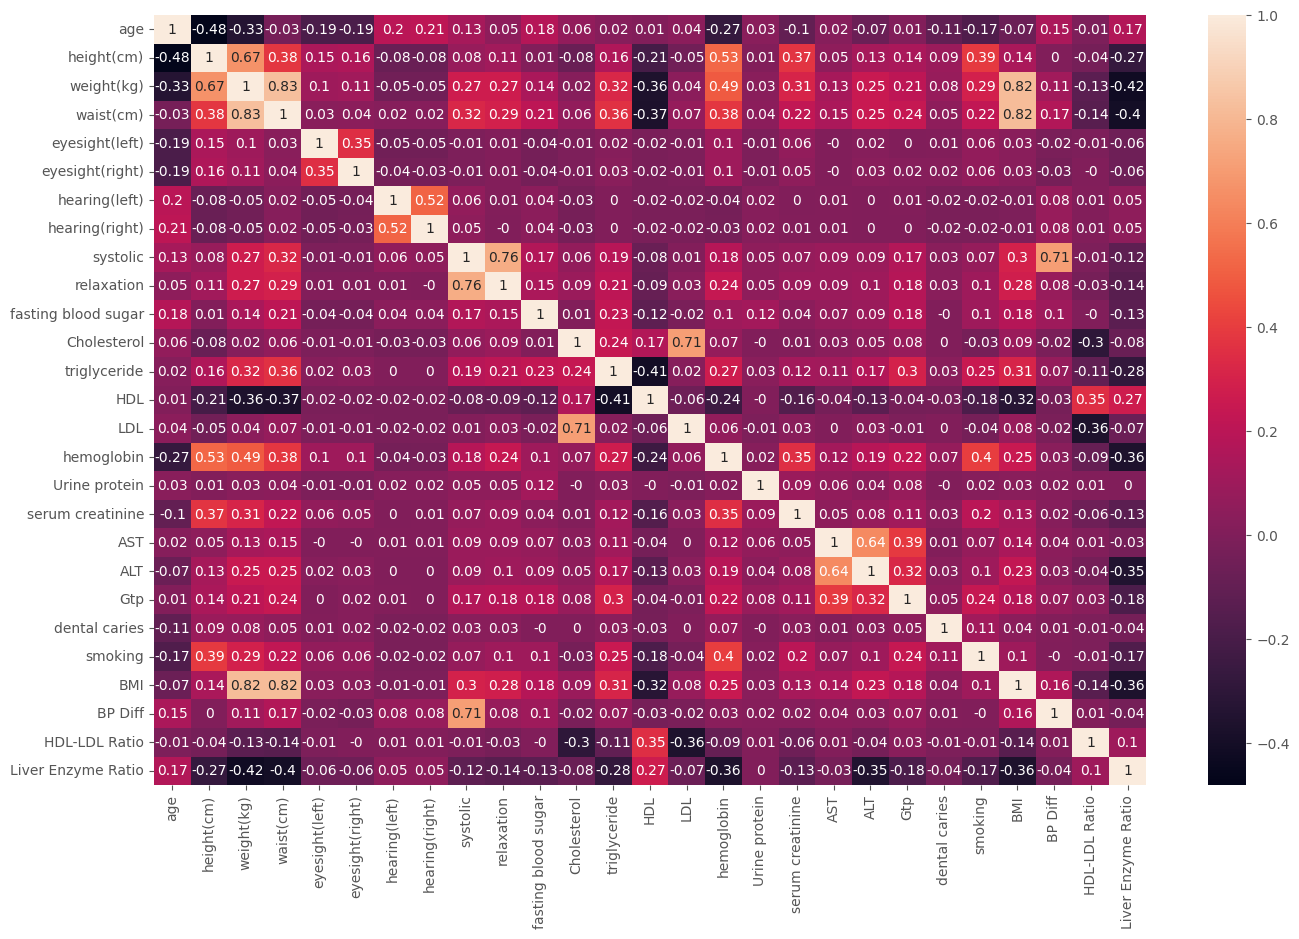

In [74]:
fig, ax = plt.subplots(figsize=(16,10))
test_corr = train_df.corr().round(2)
sns.heatmap(test_corr, annot=True, ax=ax)

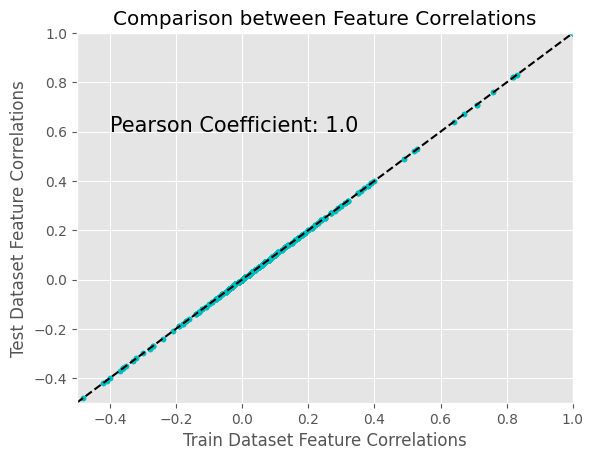

In [75]:
train_corr_lst = np.array(train_corr).flatten()
test_corr_lst = np.array(test_corr).flatten()

plt.plot(train_corr_lst, test_corr_lst, 'c.')
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_corr_lst, test_corr_lst)
abline(slope, intercept)

text = 'Pearson Coefficient: ' + str(r_value)
plt.text(-.4, .6, text, fontsize = 15)

plt.xlabel('Train Dataset Feature Correlations')
plt.ylabel('Test Dataset Feature Correlations')

plt.title('Comparison between Feature Correlations')

plt.show()

Since the Pearson Correlation Coefficient of each correlation between the train and test dataset is 1.0, there is a perfect linear relationship between the correlations. This further supports the statement that the test dataset represents the same trends as the train dataset.

Furthermore, a factor analysis can be performed on the train dataset to determine if the dataset dimension can be reduced without a loss of information. Specifically, Bartlett’s test of sphericity and the Kaiser-Meyer-Olkin (KMO) Test will be conducted to calculate the statistical significance of performing data reduction.

For Bartlett's test of sphericity:
* *H0*: The correlation matrix of the train dataset is an identity matrix.
* *HA*: The correlation matrix of the train dataset is not an identity matrix.


In [76]:
chi_square_value, p_value = calculate_bartlett_sphericity(train_corr)
print("The p-value of Bartlett's Test of Sphericity: ", p_value)

The p-value of Bartlett's Test of Sphericity:  1.7130323903294659e-93


Since $1.71*10^{-93} < \alpha = 0.05$, the test is statistically significant and the null hypothesis can be rejected: the correlation matrix is not an identity matrix. The KMO Test can then be performed to determine how suitable the correlation matrix is for feature analysis.

In [77]:
kmo_all, kmo_model = calculate_kmo(train_df)
print("KMO all: \n", kmo_all, "\n\n\nKMO value: ", kmo_model)

KMO all: 
 [0.80375933 0.46936341 0.61845987 0.95303886 0.66749952 0.67318778
 0.57584778 0.5727631  0.43829677 0.34920449 0.85678076 0.39440247
 0.61412314 0.54564615 0.46061163 0.92522704 0.67794015 0.90726865
 0.55367486 0.64121252 0.83797933 0.80605066 0.89967942 0.53032652
 0.24166928 0.63715092 0.81242604] 


KMO value:  0.582703448470397


The KMO value of $0.583$ indicates that there are some common variances between the characteristics, but it is not appropriate to perform factor analysis. As a result, no features should be merged together.

# Overall Conclusions from Exploratory Data Analysis

There is a significant amount of continuous data that will be used to predict a categorical variable, so a machine learning algorithm for classification will be used. For running the algorithm, the train dataset can be split up into train and validation datasets, and the test dataset can be used as is to test the model during training. This is because according to statistical methods #1 and #3, the given train and test datasets are very similar to each other.

Based on the results of statistical method #2, an ML algorithm can be very effective because there is a significant difference in the mean of each characteristic (except for the Blood Pressure Difference) between the smokers and non-smokers. Moreover, based on the plots, there are many outliers for a lot of characteristics. It is not useful to remove them, since they indicate an abnormal reading that may imply the presence of a certain disease or injury that the general population doesn't have. That affliction may be related to the person being a smoker. It is true that some outliers could be from faulty measurement tools, but in medicine, the instruments are very precise and used carefully to be as accurate as possible. So, outliers are not removed and log transforms will be necessary to normalize skewed characteristic distributions in the feature engineering step.

Based on the results of statistical method #3, there are a few pairs of characteristics that are moderately correlated to each other, but there are not many of these. The majority of the pairs of characteristics have little to no correlation, and the Kaiser-Meyer-Olkin Test confirms that feature analysis is not necessary because there aren't enough common variances between the features.